In [ ]:
# !pip install transformers

In [1]:
import os, gc, sys, time, collections, random, re
import numpy as np
import pandas as pd

from typing import Dict, Optional, Union, Any, List, Tuple

from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn

import torch.utils.data as D
from torch.utils.data.dataset import Dataset, IterableDataset
from torch.utils.data.dataloader import DataLoader

from transformers import DistilBertTokenizerFast
from transformers import DistilBertModel
from transformers import BertTokenizerFast
from transformers import BertModel
from transformers import Trainer
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers.data.processors.utils import InputFeatures
from transformers import TrainingArguments
from transformers.trainer_utils import EvalLoopOutput
from transformers.trainer import logging
from transformers.file_utils import is_torch_tpu_available, is_sagemaker_mp_enabled
from transformers.trainer_pt_utils import find_batch_size, nested_concat, nested_numpify, nested_truncate, nested_detach

### Folders and Dataframes

In [2]:
DATA_PATH = Path('/home/commonlit/data/')
assert DATA_PATH.exists()
MODELS_PATH = Path('/home/commonlit/models/')
if not MODELS_PATH.exists():
    os.mkdir(MODELS_PATH)
assert MODELS_PATH.exists()

In [3]:
!ls {DATA_PATH}

commonlit_lm	  commonlitreadabilityprize.zip  test.csv	 train.csv
commonlit_lm.zip  sample_submission.csv		 train-orig.csv  train_duo.csv


In [4]:
train_df = pd.read_csv(DATA_PATH/'train.csv')
test_df = pd.read_csv(DATA_PATH/'test.csv')
sample_df = pd.read_csv(DATA_PATH/'sample_submission.csv')

In [5]:
train_df

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
2,c12129c31,NaN,NaN,"Patty concluded to move very slowly, thinking ...",-0.340259,0.464009
3,c12129c31,NaN,NaN,"Patty concluded to move very slowly, thinking ...",-0.340259,0.464009
4,c12129c31,NaN,NaN,"At last the game was concluded, as Roger Farri...",-0.340259,0.464009
...,...,...,...,...,...,...
2845,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900
2846,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648
2847,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866
2848,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128


In [6]:
train_df[train_df['excerpt'].str.contains('Robin Hood')]

,id,url_legal,license,excerpt,target,standard_error
231,21ea485fb,NaN,NaN,A little within the wood there was a fair cast...,-1.302688,0.450399
233,a04741371,NaN,NaN,"The king dwelt for many months in Nottingham, ...",-0.714009,0.506864
234,5cb5ab998,NaN,NaN,"When they drew near Nottingham, all the people...",-1.541347,0.478166
235,622f6215e,NaN,NaN,About this time there was living in Nottingham...,-2.054284,0.538084


In [7]:
train_df[train_df['id'] == '21ea485fb']['excerpt'].values

array(['A little within the wood there was a fair castle, with a double moat, and surrounded by stout walls. Here dwelt that noble knight, Sir Richard Lee, to whom Robin Hood had lent the four hundred pounds to redeem his land.\nHe saw the little company of outlaws fighting their way along, so he hastened to call them to come and take shelter in his castle.\n"Welcome art thou, Robin Hood! Welcome!" he cried, as he led them in. "Much I thank thee for thy comfort and courtesy and great kindness to me in the forest. There is no man in the world I love so much as thee. For all the proud Sheriff of Nottingham, here thou shalt be safe!—Shut the gates, and draw the bridge, and let no man come in!" he shouted to his retainers. "Arm you well; make ready; guard the walls! One thing, Robin, I promise thee: here shalt thou stay for twelve days as my guest, to sup, and eat, and dine."\nSwiftly and readily tables were laid and cloths spread, and Robin Hood and his merry men sat down to a good meal.'

In [8]:
train_df[train_df['id'] == '0bf29d257']['target']

1305   -3.351956
1306   -3.351956
Name: target, dtype: float64

### Normalize

In [9]:
train_df['target'].describe()

count    2850.000000
mean       -0.958545
std         1.032773
min        -3.676268
25%        -1.686380
50%        -0.908721
75%        -0.203268
max         1.711390
Name: target, dtype: float64

In [10]:
train_target_mean = train_df['target'].mean()
train_target_std = train_df['target'].std()
train_target_mean, train_target_std

(-0.9585445991308772, 1.0327727234955468)

In [11]:
train_df['normalized_target'] = (train_df['target'] - train_target_mean) / train_target_std

In [12]:
train_df['normalized_target'].describe()

count    2850.000000
mean        0.000000
std         1.000000
min        -2.631482
25%        -0.704739
50%         0.048242
75%         0.731310
max         2.585210
Name: normalized_target, dtype: float64

In [13]:
train_df['normalized_target_check'] = train_df['normalized_target'] * train_target_std + train_target_mean

In [14]:
train_df.head(30)

,id,url_legal,license,excerpt,target,standard_error,normalized_target,normalized_target_check
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,0.598666,-0.340259
1,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,0.598666,-0.340259
2,c12129c31,NaN,NaN,"Patty concluded to move very slowly, thinking ...",-0.340259,0.464009,0.598666,-0.340259
3,c12129c31,NaN,NaN,"Patty concluded to move very slowly, thinking ...",-0.340259,0.464009,0.598666,-0.340259
4,c12129c31,NaN,NaN,"At last the game was concluded, as Roger Farri...",-0.340259,0.464009,0.598666,-0.340259
5,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,0.622763,-0.315372
6,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,0.366418,-0.580118
7,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,-0.092439,-1.054013
8,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,-0.092439,-1.054013
9,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,1.167481,0.247197


In [15]:
# !pip install seaborn

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='target'>

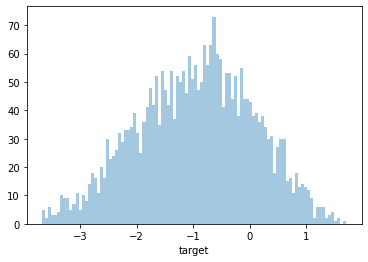

In [17]:
sns.distplot(train_df['target'],bins=100,kde=False)

<AxesSubplot:xlabel='normalized_target'>

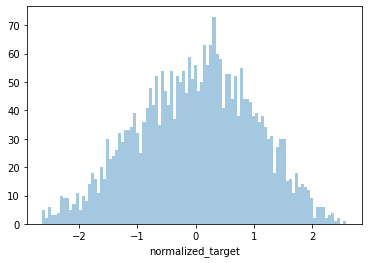

In [18]:
sns.distplot(train_df['normalized_target'],bins=100,kde=False)

### Configuration

In [19]:
import yaml

In [20]:
class CONFIG():
    batch_size = 24
    max_len = 256
    num_workers = 4
    epochs = 30
    pretrained_transformers_model = f'facebook/bart-base'
    target_field = 'normalized_target'

In [21]:
cfg = CONFIG()
cfg.model_name = 'facebook/bart-base'
cfg.num_folds = 6

In [22]:
cfg.train_target_std = float(train_target_std)
cfg.train_target_mean = float(train_target_mean)

In [23]:
# assert Path(cfg.pretrained_transformers_model).exists()

In [24]:
vars(cfg)

{'model_name': 'facebook/bart-base',
 'num_folds': 6,
 'train_target_std': 1.0327727234955468,
 'train_target_mean': -0.9585445991308772}

In [25]:
re.sub(r'(.+)/.+', r'\1', cfg.model_name)

'facebook'

In [26]:
!mkdir {MODELS_PATH}/{re.sub(r'(.+)/.+', r'\1', cfg.model_name)}

mkdir: cannot create directory ‘/home/commonlit/models/facebook’: File exists


In [27]:
with open(f'{MODELS_PATH}/{cfg.model_name}.yaml', 'w') as file:
    documents = yaml.dump(vars(cfg), file)

### Prepare Cross Validation

In [28]:
target = train_df[cfg.target_field].to_numpy()

In [29]:
num_bins = int(np.floor(np.log2(len(train_df))) + 1)
train_df.loc[:, 'bins'] = pd.cut(train_df[cfg.target_field], bins=num_bins, labels=False)

In [30]:
train_df[[cfg.target_field, 'bins']].groupby(['bins']).agg(['mean', 'count'])

normalized_target      
                  mean count
bins                        
0            -2.375317    44
1            -1.947015    79
2            -1.518286   172
3            -1.111424   269
4            -0.672413   368
5            -0.235141   420
6             0.203525   485
7             0.628164   411
8             1.054018   312
9             1.471134   184
10            1.875986    83
11            2.283473    23

In [31]:
kf = StratifiedKFold(n_splits=cfg.num_folds)

In [32]:
for i, (t_, v_) in enumerate(kf.split(X=train_df, y=train_df.bins.values)):
    train_df.loc[v_, 'kfold'] = i

In [33]:
train_df['kfold'] = train_df['kfold'].astype(np.uint8)

In [34]:
train_df = train_df.drop('bins', axis=1)

In [35]:
train_df

,id,url_legal,license,excerpt,target,standard_error,normalized_target,normalized_target_check,kfold
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,0.598666,-0.340259,0
1,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,0.598666,-0.340259,0
2,c12129c31,NaN,NaN,"Patty concluded to move very slowly, thinking ...",-0.340259,0.464009,0.598666,-0.340259,0
3,c12129c31,NaN,NaN,"Patty concluded to move very slowly, thinking ...",-0.340259,0.464009,0.598666,-0.340259,0
4,c12129c31,NaN,NaN,"At last the game was concluded, as Roger Farri...",-0.340259,0.464009,0.598666,-0.340259,0
...,...,...,...,...,...,...,...,...,...
2845,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900,2.585210,1.711390,5
2846,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648,1.111590,0.189476,5
2847,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866,1.175238,0.255209,5
2848,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128,0.719680,-0.215279,5


In [36]:
train_df[[cfg.target_field, 'kfold']].groupby(['kfold']).agg(['mean', 'count'])

normalized_target      
                   mean count
kfold                        
0              0.000969   475
1              0.011271   475
2              0.013366   475
3             -0.007179   475
4             -0.007548   475
5             -0.010879   475

In [37]:
bin_list = list(range(num_bins))
random.shuffle(bin_list)
bin_list

[5, 10, 2, 9, 3, 11, 8, 6, 4, 7, 1, 0]

In [38]:
train_df['normalized_target'].mean()

0.0

### Metrics

In [39]:
def rmse_score(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

def rmse_score_2(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [40]:
a = np.random.rand(10)
b = np.random.rand(10)

In [41]:
rmse_score(a, b), rmse_score_2(a, b)

(0.4009217051481043, 0.4009217051481043)

### Prepare train test split

In [42]:
def create_split(fold = [1]):
    valid_df = train_df[train_df['kfold'].isin(fold)]
    valid_text = valid_df['excerpt'].values
    valid_target = valid_df[cfg.target_field].values
    training_df = train_df[~train_df['kfold'].isin(fold)]
    train_text = training_df['excerpt'].values
    train_target = training_df[cfg.target_field].values
    return train_text, train_target, valid_text, valid_target

In [43]:
train_text, train_target, valid_text, valid_target = create_split([0])
len(train_text), len(valid_text)

(2375, 475)

### Prepare Tokenizers

In [44]:
tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_transformers_model)
# Save the tokenizer so that you can download the files and move it to a Kaggle dataset.
# tokenizer.save_pretrained(cfg.save_dir)

In [45]:
encoded_dict = tokenizer(train_df['excerpt'].values[0],
                                return_tensors='pt',
                                max_length=cfg.max_len,
                                padding='max_length',
                                truncation=True,
                                return_token_type_ids=True)
decoded = tokenizer.decode(encoded_dict["input_ids"].squeeze())
decoded

'<s>When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThese rugs were for prizes, one for the girls and one for the boys. And this was the game.\nThe girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.\nThis would have been an easy matter, but each traveller was obliged to wear snowshoes

In [46]:
encoded_dict.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [47]:
encoded_dict.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [48]:
encoded_dict['input_ids'].shape

torch.Size([1, 256])

In [49]:
def convert_to_list(t):
    return t.flatten().long()

class CommonLitDataset(nn.Module):
    def __init__(self, text, target, tokenizer, max_len=128):
        self.excerpt = text
        self.target = target
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __getitem__(self, idx):
        encode = self.tokenizer(self.excerpt[idx],
                                return_tensors='pt',
                                max_length=self.max_len,
                                padding='max_length',
                                truncation=True)
        return InputFeatures(input_ids=convert_to_list(encode['input_ids']),
                      attention_mask=convert_to_list(encode['attention_mask']),
                      label=torch.tensor(self.target[idx]))
    
    def __len__(self):
        return len(self.excerpt)

In [50]:
def create_train_valid_ds(tokenizer, train_text, train_target, valid_text, valid_target):
    train_ds = CommonLitDataset(train_text, train_target, tokenizer, cfg.max_len)
    valid_ds = CommonLitDataset(valid_text, valid_target, tokenizer, cfg.max_len)
    return train_ds, valid_ds

In [51]:
# encode.keys(), target.shape, encode['input_ids'].shape, encode['attention_mask'].shape

In [52]:
# encode['input_ids'][0].squeeze()

### Model

In [53]:
# You can use a Transformer model of your choice.
# transformer_model = DistilBertModel.from_pretrained(cfg.pretrained_transformers_model)
transformer_model = AutoModel.from_pretrained(cfg.pretrained_transformers_model)

Some weights of the model checkpoint at facebook/bart-base were not used when initializing BartModel: ['final_logits_bias']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [54]:
# ??transformer_model

In [55]:
# dict(transformer_out)['last_hidden_state'].shape

In [56]:
# torch.mean(transformer_out.last_hidden_state, axis=1).shape

In [57]:
# sample_layer = nn.Linear(768, 1)

In [58]:
model_config = AutoConfig.from_pretrained(cfg.pretrained_transformers_model)

In [59]:
model_config

BartConfig {
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 1024,
  "model_type": "bart",
  "no_repeat_ngram_size": 3,
  "normalize_before": false

In [60]:
from torch.nn import functional as F

In [61]:
from transformers import PreTrainedModel

In [62]:
class BartClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(
        self,
        input_dim: int,
        inner_dim: int,
        num_classes: int,
        pooler_dropout: float,
    ):
        super().__init__()
        self.dense = nn.Linear(input_dim, inner_dim)
        self.dropout = nn.Dropout(p=pooler_dropout)
        self.out_proj = nn.Linear(inner_dim, num_classes)

    def forward(self, hidden_states: torch.Tensor):
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.dense(hidden_states)
        hidden_states = torch.tanh(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.out_proj(hidden_states)
        return hidden_states

In [99]:
from transformers import PreTrainedModel

class BartClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(
        self,
        input_dim: int,
        inner_dim: int,
        num_classes: int,
        pooler_dropout: float,
    ):
        super().__init__()
        self.dense = nn.Linear(input_dim, inner_dim)
        self.dropout = nn.Dropout(p=pooler_dropout)
        self.out_proj = nn.Linear(inner_dim, num_classes)

    def forward(self, hidden_states: torch.Tensor):
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.dense(hidden_states)
        hidden_states = torch.tanh(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.out_proj(hidden_states)
        return hidden_states

class CommonLitModel(PreTrainedModel):
    def __init__(self):
        super(PreTrainedModel, self).__init__()
        self.transformer_model = AutoModel.from_pretrained(cfg.pretrained_transformers_model)
        self.drop = nn.Dropout(0.5)
        hidden_size = 768
        self.config = AutoConfig.from_pretrained(cfg.pretrained_transformers_model)
        self.classification_head = BartClassificationHead(hidden_size, hidden_size, 1, 0.5)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.out = nn.Linear(hidden_size, 1)
#         self._init_weights(self.layer_norm)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def forward(self, input_ids, attention_mask):
        transformer_out = self.transformer_model(input_ids=input_ids.squeeze(), attention_mask=attention_mask.squeeze(), output_hidden_states=True)
#         x = transformer_out.pooler_output
        x = transformer_out.decoder_hidden_states[-1][:, 0, :] # N, C, X
        x = self.classification_head(x)
        return x
    
    def floating_point_ops(self, inputs: Dict[str, Union[torch.Tensor, Any]]):
        """
        For models that inherit from :class:`~transformers.PreTrainedModel`, uses that method to compute the number of
        floating point operations for every backward + forward pass. If using another model, either implement such a
        method in the model or subclass and override this method.
        Args:
            inputs (:obj:`Dict[str, Union[torch.Tensor, Any]]`):
                The inputs and targets of the model.
        Returns:
            :obj:`int`: The number of floating-point operations.
        """
        return 0

In [100]:
model = CommonLitModel()

Some weights of the model checkpoint at facebook/bart-base were not used when initializing BartModel: ['final_logits_bias']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [101]:
encoded_dict.token_type_ids.shape

torch.Size([1, 256])

In [102]:
# transformer_model = transformer_model.cpu()
# sample_out = transformer_model(encoded_dict.input_ids.cpu(), encoded_dict.attention_mask.cpu(), encoded_dict.token_type_ids.cpu(), output_hidden_states=True)

In [103]:
transformer_model = model.transformer_model.cuda()
sample_out = transformer_model(encoded_dict.input_ids.cuda(), encoded_dict.attention_mask.cuda(), encoded_dict.token_type_ids.cuda(), output_hidden_states=True)

In [104]:
sample_out.keys()

odict_keys(['last_hidden_state', 'past_key_values', 'decoder_hidden_states', 'encoder_last_hidden_state', 'encoder_hidden_states'])

In [105]:
sample_out.last_hidden_state.shape

torch.Size([1, 256, 768])

In [106]:
sample_out.decoder_hidden_states[-1].shape

torch.Size([1, 256, 768])

In [107]:
model.cuda().classification_head(sample_out.last_hidden_state[:,0]).squeeze()

tensor(0.0916, device='cuda:0', grad_fn=<SqueezeBackward0>)

In [108]:
sample_out_cat = torch.cat(tuple([sample_out.decoder_hidden_states[i] for i in [-4, -3, -2, -1]]), dim=-1)

In [109]:
sample_out_cat[:, 0].shape

torch.Size([1, 3072])

In [110]:
sample_out.last_hidden_state.shape

torch.Size([1, 256, 768])

In [111]:
sample_out_cat.shape

torch.Size([1, 256, 3072])

### Training

In [112]:
import wandb

In [113]:
criterion = nn.MSELoss()

kl_loss = nn.KLDivLoss(reduction = 'batchmean')

def loss_fct(yhat, y):
    return criterion(yhat, y) * 0.7 + 0.3 * kl_loss(yhat, y)

loss_fct = nn.MSELoss()

def loss_fct(yhat, y):
    return torch.sqrt(criterion(yhat, y))

In [114]:
def create_training_args(fold):
    training_args = TrainingArguments(
        output_dir=str(MODELS_PATH/f"{cfg.model_name.replace('/', '_')}-{fold}"),
        overwrite_output_dir=True,
        do_train=True,
        do_eval=True,
        per_device_train_batch_size=cfg.batch_size,
        per_device_eval_batch_size=cfg.batch_size,
        num_train_epochs=cfg.epochs,
        logging_strategy="epoch",
        logging_first_step=True,
        save_steps=40000,
        fp16=True,
        evaluation_strategy="epoch",
        save_total_limit = 3,
        load_best_model_at_end=True,
        metric_for_best_model='mse',
        greater_is_better=False,
        gradient_accumulation_steps=1,
        learning_rate=5e-5
    )
    return training_args

In [115]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    return {'mse': mean_squared_error(logits, labels), 'rmse': rmse_score_2(logits, labels)}

In [116]:
tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_transformers_model)

In [117]:
logger = logging.get_logger(__name__)

class CommonLitTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        input_ids = inputs.pop("input_ids")
        attention_mask = inputs.pop("attention_mask")
        outputs = model(input_ids, attention_mask)
        logits = outputs
        loss = loss_fct(logits.flatten(),
                        labels.float().flatten())
        zero_cat = torch.zeros([1, 1]).to(outputs.device)
        return (loss, torch.cat([zero_cat, outputs])) if return_outputs else loss

In [118]:
!rm -rf /home/commonlit/models/{cfg.model_name.replace('/', '_')}-*

In [119]:
%%time

from transformers import EarlyStoppingCallback

bin_step = 1
bestmodels = []
eval_rmses = []
for i in range(0, cfg.num_folds, bin_step):
    train_bins = bin_list[i:i+bin_step]
    print('train_bins', f'{i}: {train_bins}')
    tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_transformers_model)
    train_text, train_target, valid_text, valid_target = create_split([i])
    train_ds, valid_ds = create_train_valid_ds(tokenizer, train_text, train_target, valid_text, valid_target)
    training_args = create_training_args(i)
    model = CommonLitModel()
    wandb.init(project=f"commonlit_{cfg.model_name.replace('/', '_')}")
    trainer = CommonLitTrainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=valid_ds,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=12)]
    )
    trainer.train()
    trainer.save_model()
    print('training_args.output_dir', training_args.output_dir)
    tokenizer.save_pretrained(training_args.output_dir)
    result = trainer.evaluate()
    bestmodels.append(trainer.state.best_model_checkpoint)
    print('best_model_checkpoint', trainer.state.best_model_checkpoint)
    print('result', result)
    eval_rmses.append(result['eval_rmse'])

train_bins 0: [5]


Some weights of the model checkpoint at facebook/bart-base were not used when initializing BartModel: ['final_logits_bias']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train/loss,0.9022
train/learning_rate,5e-05
train/epoch,1.0
train/global_step,99
_runtime,38
_timestamp,1624186237
_step,1


train/loss,█▁
train/learning_rate,█▁
train/epoch,▁█
train/global_step,▁█
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.920200,0.675095,0.481428,0.693850
2,0.733000,0.763692,0.601823,0.775773
3,0.612700,0.815444,0.682985,0.826429
4,0.562000,0.600986,0.386973,0.622072
5,0.465000,0.741080,0.568338,0.753882
6,0.438500,0.868599,0.772575,0.878962
7,0.393300,0.619744,0.398220,0.631047
8,0.365800,0.706310,0.517924,0.719669
9,0.347600,0.722740,0.538561,0.733867
10,0.327600,0.713366,0.526502,0.725605


training_args.output_dir /home/commonlit/models/facebook_bart-base-0


best_model_checkpoint /home/commonlit/models/facebook_bart-base-0/checkpoint-396
result {'eval_loss': 0.6009857654571533, 'eval_mse': 0.3869733214378357, 'eval_rmse': 0.6220718026161194, 'eval_runtime': 3.4481, 'eval_samples_per_second': 137.757, 'epoch': 16.0, 'eval_mem_cpu_alloc_delta': -94371840, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 94371840, 'eval_mem_gpu_peaked_delta': 919495168}
train_bins 1: [10]


Some weights of the model checkpoint at facebook/bart-base were not used when initializing BartModel: ['final_logits_bias']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train/loss,0.2527
train/learning_rate,2e-05
train/epoch,16.0
train/global_step,1584
_runtime,786
_timestamp,1624187171
_step,34
eval/loss,0.60099
eval/mse,0.38697
eval/rmse,0.62207
eval/runtime,3.4481


train/loss,█▇▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁
train/learning_rate,██▇▇▆▆▅▅▅▄▄▃▃▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██████
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
eval/loss,▃▅▇▁▅█▁▄▄▄▄▄▃▄▂▃▁
eval/mse,▃▅▆▁▄█▁▃▄▄▄▃▃▄▂▃▁
eval/rmse,▃▅▇▁▅█▁▄▄▄▄▄▃▄▂▃▁
eval/runtime,▁▅▃▂▃▂▃▂▁▄▃▃▃▅▄▃█


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.913900,0.689496,0.497056,0.705022
2,0.726700,0.679693,0.494662,0.703322
3,0.599500,0.595957,0.383194,0.619026
4,0.555500,0.522442,0.278199,0.527446
5,0.478900,0.607564,0.390715,0.625072
6,0.432800,0.814517,0.676899,0.822739
7,0.396300,0.590636,0.359907,0.599923
8,0.360300,0.634603,0.431144,0.656616
9,0.347100,0.615583,0.387360,0.622383
10,0.316800,0.543597,0.303935,0.551303


training_args.output_dir /home/commonlit/models/facebook_bart-base-1


best_model_checkpoint /home/commonlit/models/facebook_bart-base-1/checkpoint-396
result {'eval_loss': 0.5224424600601196, 'eval_mse': 0.27819913625717163, 'eval_rmse': 0.5274458527565002, 'eval_runtime': 3.477, 'eval_samples_per_second': 136.613, 'epoch': 16.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 920281600}
train_bins 2: [2]


Some weights of the model checkpoint at facebook/bart-base were not used when initializing BartModel: ['final_logits_bias']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train/loss,0.2496
train/learning_rate,2e-05
train/epoch,16.0
train/global_step,1584
_runtime,789
_timestamp,1624187977
_step,34
eval/loss,0.52244
eval/mse,0.2782
eval/rmse,0.52745
eval/runtime,3.477


train/loss,█▆▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁
train/learning_rate,██▇▇▆▆▅▅▅▄▄▃▃▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██████
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
eval/loss,▅▅▃▁▃█▃▄▃▂▁▂▃▂▃▃▁
eval/mse,▅▅▃▁▃█▂▄▃▁▂▂▃▂▂▃▁
eval/rmse,▅▅▃▁▃█▃▄▃▂▂▂▃▂▃▃▁
eval/runtime,▁▄▄▂▄▃▃▄▂▄▃▃▆▅▃▃█


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.964500,1.134931,1.307677,1.143537
2,0.742200,0.522324,0.279938,0.529092
3,0.605800,0.492463,0.252281,0.502276
4,0.536000,0.528317,0.285541,0.534360
5,0.487200,0.875101,0.783320,0.885054
6,0.440200,0.790485,0.637736,0.798584
7,0.406200,0.572882,0.336588,0.580162
8,0.378000,0.843286,0.721643,0.849496
9,0.341000,0.638468,0.414083,0.643493
10,0.316500,0.526670,0.284087,0.532998


training_args.output_dir /home/commonlit/models/facebook_bart-base-2


best_model_checkpoint /home/commonlit/models/facebook_bart-base-2/checkpoint-297
result {'eval_loss': 0.49246329069137573, 'eval_mse': 0.25228121876716614, 'eval_rmse': 0.5022760629653931, 'eval_runtime': 3.464, 'eval_samples_per_second': 137.126, 'epoch': 15.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 919495168}
train_bins 3: [9]


Some weights of the model checkpoint at facebook/bart-base were not used when initializing BartModel: ['final_logits_bias']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train/loss,0.2581
train/learning_rate,3e-05
train/epoch,15.0
train/global_step,1485
_runtime,740
_timestamp,1624188733
_step,32
eval/loss,0.49246
eval/mse,0.25228
eval/rmse,0.50228
eval/runtime,3.464


train/loss,█▇▅▄▃▃▂▂▂▂▁▁▁▁▁▁
train/learning_rate,██▇▇▆▆▅▅▄▄▃▃▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██████
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
eval/loss,█▁▁▁▅▄▂▅▃▁▃▂▂▂▂▁
eval/mse,█▁▁▁▅▄▂▄▂▁▂▂▁▂▂▁
eval/rmse,█▁▁▁▅▄▂▅▃▁▃▂▁▂▂▁
eval/runtime,▆▃▃▄▆▄▄▄▁▂▄▂▁▃▄█


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.940400,0.675774,0.476297,0.690142
2,0.741400,0.532810,0.293197,0.541476
3,0.597400,0.507707,0.265875,0.515630
4,0.541300,0.719152,0.524701,0.724362
5,0.467700,0.660530,0.449780,0.670656
6,0.426700,0.633044,0.412531,0.642286
7,0.402800,0.514191,0.271319,0.520883
8,0.350300,0.600195,0.377938,0.614767
9,0.344200,0.499813,0.257564,0.507507
10,0.321400,0.576568,0.344830,0.587223


training_args.output_dir /home/commonlit/models/facebook_bart-base-3


best_model_checkpoint /home/commonlit/models/facebook_bart-base-3/checkpoint-1188
result {'eval_loss': 0.4622667133808136, 'eval_mse': 0.22008486092090607, 'eval_rmse': 0.46913203597068787, 'eval_runtime': 3.4029, 'eval_samples_per_second': 139.586, 'epoch': 24.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 919495168}
train_bins 4: [3]


Some weights of the model checkpoint at facebook/bart-base were not used when initializing BartModel: ['final_logits_bias']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train/loss,0.1918
train/learning_rate,1e-05
train/epoch,24.0
train/global_step,2376
_runtime,1187
_timestamp,1624189936
_step,50
eval/loss,0.46227
eval/mse,0.22008
eval/rmse,0.46913
eval/runtime,3.4029


train/loss,█▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eval/loss,▇▃▂█▆▆▂▅▂▄▄▁▃▄▂▄▃▃▃▃▃▄▄▃▁
eval/mse,▇▃▂█▆▅▂▅▂▄▄▁▃▃▂▃▃▃▃▃▃▃▄▃▁
eval/rmse,▇▃▂█▇▆▂▅▂▄▄▁▃▄▂▄▃▄▃▃▃▄▄▃▁
eval/runtime,▂▇█▆▅▇▂▂▂▄█▂▄▃▃▁▂▅▄▃▄▃▃▄▅


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.919000,0.744316,0.573627,0.757382
2,0.728400,0.583457,0.354008,0.594986
3,0.612000,0.791084,0.637500,0.798436
4,0.516300,0.716234,0.522835,0.723073
5,0.487700,0.769845,0.605809,0.778337
6,0.440100,0.742490,0.568028,0.753677
7,0.384700,0.824587,0.706653,0.840627
8,0.364100,0.622887,0.401073,0.633303
9,0.330800,0.647421,0.432708,0.657805
10,0.316100,0.554256,0.315237,0.561460


training_args.output_dir /home/commonlit/models/facebook_bart-base-4


best_model_checkpoint /home/commonlit/models/facebook_bart-base-4/checkpoint-990
result {'eval_loss': 0.55425626039505, 'eval_mse': 0.3152370750904083, 'eval_rmse': 0.5614597797393799, 'eval_runtime': 3.4563, 'eval_samples_per_second': 137.431, 'epoch': 22.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 919495168}
train_bins 5: [11]


Some weights of the model checkpoint at facebook/bart-base were not used when initializing BartModel: ['final_logits_bias']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train/loss,0.2065
train/learning_rate,1e-05
train/epoch,22.0
train/global_step,2178
_runtime,1404
_timestamp,1624191358
_step,46
eval/loss,0.55426
eval/mse,0.31524
eval/rmse,0.56146
eval/runtime,3.4563


train/loss,█▇▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eval/loss,▆▂▇▅▇▆█▃▃▁▃▂▃▃▂▂▂▂▂▄▂▂▁
eval/mse,▆▂▇▅▆▆█▃▃▁▃▂▃▃▂▁▂▂▂▄▂▂▁
eval/rmse,▆▂▇▅▆▆█▃▃▁▃▂▃▃▂▂▂▂▂▄▂▂▁
eval/runtime,▇▇▅▇█▃▅▇▅██▇█▆█▅▇▇▇▅▆▇▁


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.928100,0.765762,0.601483,0.775554
2,0.728700,0.605997,0.377118,0.614099
3,0.623500,0.795099,0.647638,0.804760
4,0.548700,0.567963,0.327455,0.572237
5,0.492900,0.621169,0.393211,0.627065
6,0.438800,0.570811,0.334122,0.578033
7,0.407000,0.688532,0.487701,0.698356
8,0.377400,0.696015,0.496907,0.704916
9,0.341600,0.567621,0.328714,0.573336
10,0.331600,0.672346,0.463139,0.680543


training_args.output_dir /home/commonlit/models/facebook_bart-base-5


best_model_checkpoint /home/commonlit/models/facebook_bart-base-5/checkpoint-1188
result {'eval_loss': 0.540481448173523, 'eval_mse': 0.2982543408870697, 'eval_rmse': 0.546126663684845, 'eval_runtime': 3.4535, 'eval_samples_per_second': 137.541, 'epoch': 24.0, 'eval_mem_cpu_alloc_delta': -262144, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 262144, 'eval_mem_gpu_peaked_delta': 919495168}
CPU times: user 2h 55min 48s, sys: 1h 13min 13s, total: 4h 9min 1s
Wall time: 1h 43min 11s


In [120]:
BEST_MODEL_FOLDER = MODELS_PATH/cfg.model_name/'best'
!rm -rf {BEST_MODEL_FOLDER}
!mkdir -p {BEST_MODEL_FOLDER}

In [121]:
'Mean best RSME losses', np.array(eval_rmses).mean()

('Mean best RSME losses', 0.5380853662888209)

### Verify the model

In [122]:
from sklearn.svm import SVR
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm

In [123]:
cfg.model_offset = 0
cfg.model_limit = 6
cfg.n_folds = 5
cfg.svm_kernels = ['rbf']
cfg.svm_c = 5

In [124]:
train_df = pd.read_csv(DATA_PATH/'train.csv')
test_df = pd.read_csv(DATA_PATH/'test.csv')

In [125]:
train_target_mean = train_df['target'].mean()
train_target_std = train_df['target'].std()
train_df['normalized_target'] = (train_df['target'] - train_target_mean) / train_target_std

In [126]:
num_bins = int(np.ceil(np.log2(len(train_df))))
train_df['bins'] = pd.cut(train_df['target'], bins=num_bins, labels=False)
bins = train_df['bins'].values

In [127]:
%%time

inference_models = []
for i in range(cfg.model_offset, cfg.model_limit):
    print(f'Model {i}')
    inference_model = CommonLitModel()
    inference_model = inference_model.cuda()
    inference_model.load_state_dict(torch.load(str(MODELS_PATH/f"{cfg.model_name.replace('/', '_')}-{i}/pytorch_model.bin")))
    inference_model.eval();
    inference_models.append(inference_model)

Model 0


Some weights of the model checkpoint at facebook/bart-base were not used when initializing BartModel: ['final_logits_bias']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model 1


Some weights of the model checkpoint at facebook/bart-base were not used when initializing BartModel: ['final_logits_bias']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model 2


Some weights of the model checkpoint at facebook/bart-base were not used when initializing BartModel: ['final_logits_bias']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model 3


Some weights of the model checkpoint at facebook/bart-base were not used when initializing BartModel: ['final_logits_bias']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model 4


Some weights of the model checkpoint at facebook/bart-base were not used when initializing BartModel: ['final_logits_bias']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model 5


Some weights of the model checkpoint at facebook/bart-base were not used when initializing BartModel: ['final_logits_bias']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CPU times: user 40.4 s, sys: 11.8 s, total: 52.2 s
Wall time: 29.7 s


In [128]:
tokenizers = []
for i in range(cfg.model_offset, cfg.model_limit):
    tokenizer = AutoTokenizer.from_pretrained(MODELS_PATH/f"{cfg.model_name.replace('/', '_')}-{i}")
    tokenizers.append(tokenizer)

In [129]:
def get_cls_embeddings(dl, transformer_model):
    cls_embeddings = []
    with torch.no_grad():
        for input_features in tqdm(dl, total=len(dl)):
            output = transformer_model(input_features['input_ids'].cuda(), input_features['attention_mask'].cuda())
            cls_embeddings.extend(output[0][:,0,:].detach().cpu().numpy())
    return np.array(cls_embeddings)

In [130]:
def rmse_score(X, y):
    return np.sqrt(mean_squared_error(X, y))

In [131]:
def convert_to_list(t):
    return t.flatten().long()

class CommonLitDataset(nn.Module):
    def __init__(self, text, test_id, tokenizer, max_len=128):
        self.excerpt = text
        self.test_id = test_id
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __getitem__(self,idx):
        encode = self.tokenizer(self.excerpt[idx],
                                return_tensors='pt',
                                max_length=self.max_len,
                                padding='max_length',
                                truncation=True)
        return {'input_ids': convert_to_list(encode['input_ids']),
                'attention_mask': convert_to_list(encode['attention_mask']),
                'id': self.test_id[idx]}
    
    def __len__(self):
        return len(self.excerpt)

In [132]:
def create_dl(df, tokenizer):
    text = df['excerpt'].values
    ids = df['id'].values
    ds = CommonLitDataset(text, ids, tokenizer, max_len=cfg.max_len)
    return DataLoader(ds, 
                      batch_size = cfg.batch_size,
                      shuffle=False,
                      num_workers = 1,
                      pin_memory=True,
                      drop_last=False
                     )

In [133]:
%%time

train_target = train_df['normalized_target'].values

def calc_mean(scores):
    return np.mean(np.array(scores), axis=0)

final_scores = []
final_rmse = []
kernel_rmse_score_mean = []
for j, (inference_model, tokenizer) in enumerate(zip(inference_models, tokenizers)):
    print('Model', j)
    test_dl = create_dl(test_df, tokenizer)
    train_dl = create_dl(train_df, tokenizer)
    transformer_model = inference_model.transformer_model if hasattr(inference_model, 'transformer_model') else inference_model
    transformer_model.cuda()
    X = get_cls_embeddings(train_dl, transformer_model)
    y = train_target
    X_test = get_cls_embeddings(test_dl, transformer_model)
    kfold = StratifiedKFold(n_splits=cfg.n_folds)
    scores = []
    rmse_scores = []
    for kernel in cfg.svm_kernels:
        print('Kernel', kernel)
        kernel_scores = []
        kernel_rmse_scores = []
        for k, (train_idx, valid_idx) in enumerate(kfold.split(X, bins)):

            print('Fold', k, train_idx.shape, valid_idx.shape)
            model = SVR(C=cfg.svm_c, kernel=kernel, gamma='auto')

            X_train, y_train = X[train_idx], y[train_idx]
            X_valid, y_valid = X[valid_idx], y[valid_idx]
            model.fit(X_train, y_train)
            prediction = model.predict(X_valid)
            kernel_rmse_scores.append(rmse_score(prediction, y_valid))
            print('rmse_score', kernel_rmse_scores[k])
            kernel_scores.append(model.predict(X_test))
        scores.append(calc_mean(kernel_scores))
        kernel_rmse_score = calc_mean(kernel_rmse_scores)
        kernel_rmse_score_mean.append(kernel_rmse_score)
        rmse_scores.append(kernel_rmse_score)
    final_scores.append(calc_mean(scores))
    final_rmse.append(calc_mean(rmse_scores))
print('FINAL RMSE score', np.mean(np.array(final_rmse)))

Model 0



Kernel rbf
Fold 0 (2280,) (570,)
rmse_score 0.5136740798989949
Fold 1 (2280,) (570,)
rmse_score 0.3136938145370675
Fold 2 (2280,) (570,)
rmse_score 0.3014303789466946
Fold 3 (2280,) (570,)
rmse_score 0.3421802747964771
Fold 4 (2280,) (570,)
rmse_score 0.32339656815985013
Model 1



Kernel rbf
Fold 0 (2280,) (570,)
rmse_score 0.355620209604875
Fold 1 (2280,) (570,)
rmse_score 0.4485317551986633
Fold 2 (2280,) (570,)
rmse_score 0.3167216566401618
Fold 3 (2280,) (570,)
rmse_score 0.33731358366242997
Fold 4 (2280,) (570,)
rmse_score 0.3344786526601921
Model 2



Kernel rbf
Fold 0 (2280,) (570,)
rmse_score 0.3756103788640033
Fold 1 (2280,) (570,)
rmse_score 0.41053107137349254
Fold 2 (2280,) (570,)
rmse_score 0.4106707030791167
Fold 3 (2280,) (570,)
rmse_score 0.3886869703568702
Fold 4 (2280,) (570,)
rmse_score 0.38434052100578053
Model 3



Kernel rbf
Fold 0 (2280,) (570,)
rmse_score 0.1448674873834343
Fold 1 (2280,) (570,)
rmse_score 0.14504963695892842
Fold 2 (2280,) (570,)
rmse_score 0.33449711766008106
Fold 3 (2280,) (570,)
rmse_score 0.2892411947319308
Fold 4 (2280,) (570,)
rmse_score 0.1473575566967322
Model 4



Kernel rbf
Fold 0 (2280,) (570,)
rmse_score 0.16530504193017784
Fold 1 (2280,) (570,)
rmse_score 0.16280328534741897
Fold 2 (2280,) (570,)
rmse_score 0.17435773548212966
Fold 3 (2280,) (570,)
rmse_score 0.43104307429818767
Fold 4 (2280,) (570,)
rmse_score 0.24247620953240945
Model 5



Kernel rbf
Fold 0 (2280,) (570,)
rmse_score 0.13918024777860363
Fold 1 (2280,) (570,)
rmse_score 0.14542208252328098
Fold 2 (2280,) (570,)
rmse_score 0.14238117774170886
Fold 3 (2280,) (570,)
rmse_score 0.14284580996312293
Fold 4 (2280,) (570,)
rmse_score 0.4791066200218683
FINAL RMSE score 0.29476049656115616
CPU times: user 6min 38s, sys: 44.8 s, total: 7min 23s
Wall time: 2min 40s


In [134]:
# (train_df['target'] - cfg.train_target_mean) / cfg.train_target_std
final_scores_normalized = np.array(final_scores) * train_target_std + train_target_mean

In [135]:
kernel_rmse_score_mean_array = np.array(kernel_rmse_score_mean)
kernel_rmse_score_mean_sum = np.sum(kernel_rmse_score_mean_array)
prop_losses = kernel_rmse_score_mean_array / kernel_rmse_score_mean_sum
prop_losses_sum = (1 - prop_losses).sum()
weights = (1 - prop_losses) / prop_losses_sum
weights

array([0.1594162 , 0.15945486, 0.15544768, 0.17600282, 0.17340247,
       0.17627597])

In [139]:
def calc_mean(scores, weights=weights):
    return np.average(np.array(scores), weights=weights, axis=0)

In [140]:
target_mean = train_df['target'].mean()
final_scores_flat = calc_mean(final_scores_normalized).flatten()
final_scores_mean = final_scores_flat.mean()
target_mean, np.array(final_scores_normalized).mean()

(-0.9585445991308772, -0.9634570844879007)

In [141]:
final_scores_flat

array([-0.83901323, -0.51576877, -0.53936732, -2.32060566, -1.83808951,
       -1.07579473,  0.41356177])

In [142]:
BEST_MODEL_FOLDER

PosixPath('/home/commonlit/models/facebook/bart-base/best')

### Packaging and Sending to Kaggle

In [144]:
from shutil import copyfile

def normalize_name(path_name):
    return path_name.replace('facebook/', 'facebook_')

for i, best_model in enumerate(bestmodels):
    print(f'Processing {i}th model')
    best_model_file = f'{best_model}/pytorch_model.bin'
    if Path(best_model_file).exists():
        copyfile(best_model_file, f'{BEST_MODEL_FOLDER}/{i}_pytorch_model.bin')
        tokenizer_path = Path(BEST_MODEL_FOLDER/f'tokenizer-{i}')
        tokenizer_path.mkdir(parents=True, exist_ok=True)
        assert tokenizer_path.exists()

        tokenizer_json = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/tokenizer.json'))
        assert tokenizer_json.exists(), f'{tokenizer_json} does not exist'
        copyfile(tokenizer_json, tokenizer_path/'tokenizer.json')

        vocab_txt = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/vocab.json'))
        assert vocab_txt.exists(), f'{vocab_txt} does not exist'
        copyfile(vocab_txt, tokenizer_path/'vocab.json')
        
        merges_txt = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/merges.txt'))
        assert merges_txt.exists(), f'{merges_txt} does not exist'
        copyfile(merges_txt, tokenizer_path/'merges.txt')

        config_json = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/config.json'))
        assert config_json.exists()
        copyfile(config_json, tokenizer_path/'config.json')
    else:
        print(f'{best_model_file} is missing')

Processing 0th model
Processing 1th model
Processing 2th model
Processing 3th model
Processing 4th model
Processing 5th model


In [145]:
import shutil

shutil.make_archive(MODELS_PATH/cfg.model_name/'best_models', 'zip', BEST_MODEL_FOLDER)

'/home/commonlit/models/facebook/bart-base/best_models.zip'

In [146]:
!ls {MODELS_PATH/cfg.model_name}

best  best_models.zip


In [147]:
!mv {MODELS_PATH}/{cfg.model_name}.yaml {MODELS_PATH/cfg.model_name}

In [148]:
# transformer_model.save_pretrained(save_directory=f'{MODELS_PATH/cfg.model_name}/lm')

In [149]:
!du -h {MODELS_PATH/cfg.model_name}/*

4.0K	/home/commonlit/models/facebook/bart-base/bart-base.yaml
2.5M	/home/commonlit/models/facebook/bart-base/best/tokenizer-0
2.5M	/home/commonlit/models/facebook/bart-base/best/tokenizer-1
2.5M	/home/commonlit/models/facebook/bart-base/best/tokenizer-2
2.5M	/home/commonlit/models/facebook/bart-base/best/tokenizer-3
2.5M	/home/commonlit/models/facebook/bart-base/best/tokenizer-4
2.5M	/home/commonlit/models/facebook/bart-base/best/tokenizer-5
3.2G	/home/commonlit/models/facebook/bart-base/best
2.8G	/home/commonlit/models/facebook/bart-base/best_models.zip


In [155]:
!rm {MODELS_PATH/cfg.pretrained_transformers_model}/lm.zip

In [163]:
{MODELS_PATH/cfg.pretrained_transformers_model}

{PosixPath('/home/commonlit/models/facebook/bart-base')}

In [164]:
transformer_model.save_pretrained(save_directory=f'{MODELS_PATH/cfg.pretrained_transformers_model}/lm')

In [165]:
shutil.make_archive(MODELS_PATH/cfg.model_name/'lm', 'zip', f'{MODELS_PATH/cfg.pretrained_transformers_model}/lm')

'/home/commonlit/models/facebook/bart-base/lm.zip'

In [166]:
!kaggle datasets init -p {MODELS_PATH/cfg.model_name}

Data package template written to: /home/commonlit/models/facebook/bart-base/dataset-metadata.json


In [167]:
dataset_json_path = Path(MODELS_PATH/cfg.model_name/'dataset-metadata.json')
assert dataset_json_path.exists()

In [168]:
!cat {str(dataset_json_path)}

{
  "title": "INSERT_TITLE_HERE",
  "id": "gilfernandes/INSERT_SLUG_HERE",
  "licenses": [
    {
      "name": "CC0-1.0"
    }
  ]
}

In [170]:
with open(dataset_json_path, 'r') as f:
    dataset_json = f.read()
    dataset_json = dataset_json.replace('INSERT_TITLE_HERE', f'commonlit-{cfg.model_name}-standardized').replace('INSERT_SLUG_HERE', f'commonlit-{cfg.model_name}-standardized').replace('facebook/', '')
    print(dataset_json)
with(open(dataset_json_path, 'w')) as f:
    f.write(dataset_json)

{
  "title": "commonlit-bart-base-standardized",
  "id": "gilfernandes/commonlit-bart-base-standardized",
  "licenses": [
    {
      "name": "CC0-1.0"
    }
  ]
}


In [171]:
!rm -rf {MODELS_PATH/cfg.model_name}/best
!rm -rf {MODELS_PATH/cfg.model_name}/lm

In [172]:
!ls -la {MODELS_PATH/cfg.model_name}

total 3329300
drwxr-xr-x 2 root root         94 Jun 20 14:43 .
drwxr-xr-x 3 root root         23 Jun 20 13:47 ..
-rw-r--r-- 1 root root        120 Jun 20 10:45 bart-base.yaml
-rw-r--r-- 1 root root 2924817312 Jun 20 13:44 best_models.zip
-rw-r--r-- 1 root root        163 Jun 20 14:42 dataset-metadata.json
-rw-r--r-- 1 root root  484376481 Jun 20 14:41 lm.zip


In [173]:
# Create from scratch
!kaggle datasets create -p {MODELS_PATH/cfg.model_name}

Starting upload for file best_models.zip
100%|██████████████████████████████████████| 2.72G/2.72G [04:50<00:00, 10.1MB/s]
Upload successful: best_models.zip (3GB)
Starting upload for file bart-base.yaml
100%|███████████████████████████████████████████| 120/120 [00:05<00:00, 22.2B/s]
Upload successful: bart-base.yaml (120B)
Starting upload for file lm.zip
100%|████████████████████████████████████████| 462M/462M [01:06<00:00, 7.29MB/s]
Upload successful: lm.zip (462MB)
Your private Dataset is being created. Please check progress at /api/v1/datasets/status//gilfernandes/commonlit-bart-base-standardized


In [ ]:
# Update the existing dataset
!kaggle datasets version -p {MODELS_PATH/cfg.model_name} -m "Version using hidden layer prior to last"

In [ ]:
state_dict = torch.load(str(MODELS_PATH/f'distilroberta-0/checkpoint-105/pytorch_model.bin'))

In [ ]:
loaded_model = CommonLitModel()

In [ ]:
loaded_model.load_state_dict(state_dict)